# Predicting sentiment with ML (+ 80% accuracy)

## Text treatment

In [152]:
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import KFold

# XGBoost for Machine Learning (Gradient Boosting Machine (GBM))
import xgboost as xgb

# nltk for preprocessing of text data
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Random seeds for consistent results
#from tensorflow import set_random_seed
seed = 1234
#np.random.seed(seed)
#set_random_seed(seed)

# sklearn for preprocessing and machine learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Import Dataset

In [77]:
df = pd.read_csv('Tweets.csv',sep=',', delimiter=None)

In [78]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [85]:
print(df.ndim) #2
df.shape


2


(14640, 15)

In [86]:
df.columns.values

array(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], dtype=object)

In [88]:
# Select features
df = df[['tweet_id', 'text', 'airline_sentiment']]
print('Feature selected DataFrame:')
df.head(2)

Feature selected DataFrame:


,tweet_id,text,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive


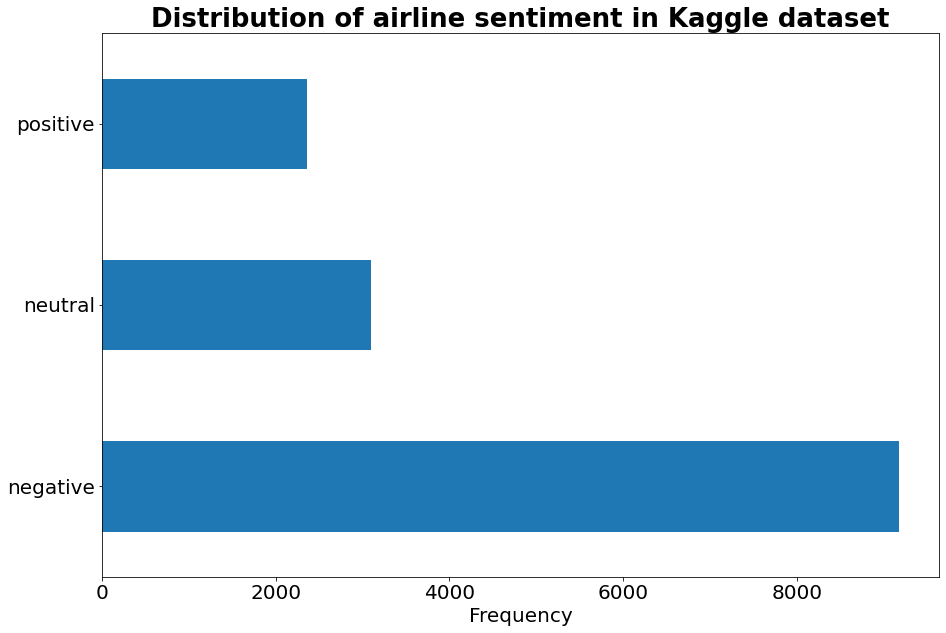

In [94]:
# Plot sentiment distribution
df['airline_sentiment'].value_counts().plot(kind = 'barh',
                                            figsize = (15,10));
plt.title('Distribution of airline sentiment in Kaggle dataset', 
          fontsize = 26, weight = 'bold')
plt.xlabel('Frequency', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

## Preprocessing

In [95]:
text = "God is Great! I won a lottery."
print(word_tokenize(text))

['God', 'is', 'Great', '!', 'I', 'won', 'a', 'lottery', '.']


In [111]:
 
class PreProcessor:
    def __init__(self, df, column_name):
        self.data = df
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []
    
    # Tokenization
    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence
    
    # Removing stop words
    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        stop_words = nltk.corpus.stopwords.words("english")
        filtered_sentence = []
        for w in sentence:
            if w not in stop_words and len(w) > 1 and w[:2] != '//' and w != 'https': 
                filtered_sentence.append(w)
        return filtered_sentence
    
    # Stemming
    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get truncated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]
    
    # Transform the tokens back to one string
    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)
    
    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)
            
        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.preprocessed
    


In [112]:
# Preprocess text and put it in a new column
preprocessor = PreProcessor(df, 'text')
df['cleaned_text'] = preprocessor.full_preprocess()


## Split data into train, validation and test sets

We split the data into a training set, validation set and test set. This is crucial for training and evaluation of good machine learning models.

The data will be shuffled and we take 1000 tweets for our test set. The remaining data will be split 80/20. This means that 80% will be used for training and 20% for validation set. During the model training phase our goal is to maximize the accuracy on the validation set. The test set is to check that our model truly generalizes to data it has never seen before.


In [113]:
# Shuffling so we can get random tweets for the test set
df = df.sample(frac = 1) 

# Keep 1000 samples of the data as test set
test_set = df[:1000]

In [114]:
df.head(5)

,tweet_id,text,airline_sentiment,cleaned_text
964,569988078015815680,@United will not have to honor absurdly low mi...,neutral,unit honor absurd low mistak fare http vía usa...
4175,567793696956231680,"@united thanks for the offer, but I finally ma...",negative,unit thank offer final made destin albeit hour...
459,567846970141716481,@VirginAmerica @JezzieGoldz would have been a ...,positive,virginamerica jezziegoldz would rough trip luc...
12686,570062369096908801,@AmericanAir on flight 1074 that has been dela...,negative,americanair flight 1074 delay hour human error...
12755,570036187815149570,@AmericanAir ok makes no sense tho Since you'l...,negative,americanair ok make sens tho sinc ll give free...


In [118]:
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_text'][1000:], 
                                                  df['airline_sentiment'][1000:], 
                                                  test_size=0.2, 
                                                  random_state=seed)

# Get sentiment labels for test set
y_test = test_set['airline_sentiment']

## Data vectorization

Many machine learning models can only be trained on numerical input in the form of vectors or matrices. To prepare our tweets for the machine learning models we create a term frequency-inverse document frequency (tf-idf) vectorization. The result of this vectorization is a sparse matrix which contains a convenient representation of our tweets.

The machine learning will learn which word frequency is important to predict a correct sentiment.


In [120]:
# Create matrix based on word frequency in tweets
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['cleaned_text'])

In [126]:
# Print the size of our data
print(f'Training size: {X_train.shape[0]} tweets\n\
        Validation size: {X_val.shape[0]} tweets\n\
        Test size: {X_test.shape[0]} tweets\n\
        Amount of words (columns): {X_train.shape[1]} words')

Training size: 10912 tweets
        Validation size: 2728 tweets
        Test size: 1000 tweets
        Amount of words (columns): 9643 words


## ML Models


Multinomial Naive Bayes

Multinomial Naive Bayes is the go-to method for text mining and is great to set a benchmark for sentiment analysis. It is easy to implement with sklearn's "MultinomialNB" class

In [127]:
# Multinomial Naive Bayes
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [128]:
# Check results
train_pred = multi_nb.predict(X_train)
val_pred = multi_nb.predict(X_val)
print(f'Accuracy on training set (MultinomialNB): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (MultinomialNB): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (MultinomialNB): 73.3779%
Accuracy on validation set (MultinomialNB): 66.4223%


## Sklearn's Gradient Boosting Machine (GBM)

The Gradient Boosting Machine (GBM) is a powerful machine learning technique. The model basically trains decision trees models. It keeps training additive models on the residuals of the previous model. In this way we can get much better results than with a single decision tree. A GBM is however the most powerful if there is also plenty of labeled data.

In [141]:
# sklearn's Gradient Boosting Classifier (GBM)
gbm = GradientBoostingClassifier(n_estimators=200, 
                                 max_depth=6, 
                                 random_state=seed)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [142]:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=1234,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [143]:
# Check results
train_pred = gbm.predict(X_train)
val_pred = gbm.predict(X_val)
print(f'Accuracy on training set (GBM): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (GBM): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (GBM): 87.7199%
Accuracy on validation set (GBM): 75.6965%



## XGBoost (GBM)

XGBoost is a Python package which provides an efficient implementation of a GBM. It often allows for more elaborate optimization than sklearn's GBM. In my experience, XGBoost often performs slightly better than sklearn's GBM.

In [145]:
# Hyperparameters that you can tweak
# There are a lot more tweakable hyperparameters that you can find at 
# https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_params = {'objective' : 'multi:softmax',
              'eval_metric' : 'mlogloss',
              'eta' : 0.1,
              'max_depth' : 6,
              'num_class' : 3,
              'lambda' : 0.8,
              'estimators' : 200,
              'seed' : seed
              
}

# Transform categories into numbers
# negative = 0, neutral = 1 and positive = 2
target_train = y_train.astype('category').cat.codes
target_val = y_val.astype('category').cat.codes

# Transform data into a matrix so that we can use XGBoost
d_train = xgb.DMatrix(X_train, label = target_train)
d_val = xgb.DMatrix(X_val, label = target_val)

# Fit XGBoost
watchlist = [(d_train, 'train'), (d_val, 'validation')]
bst = xgb.train(xgb_params, 
                d_train, 
                400,  
                watchlist,
                early_stopping_rounds = 50, 
                verbose_eval = 0)

[22:09:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [146]:
# Check results for XGBoost
train_pred = bst.predict(d_train)
val_pred = bst.predict(d_val)
print(f'Accuracy on training set (XGBoost): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (XGBoost): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

Accuracy on training set (XGBoost): 89.6811%
Accuracy on validation set (XGBoost): 76.7595%



## Simple neural network

Over the past years neural networks have given us extraordinary results on natural language processing (NLP) tasks with complex implementations. In this implementation however we will go back to basics and created a simple fully-connected neural networks with 20 neurons. The reason for this is that we have limited data and a small neural network model is already very prone to overfitting.


In [148]:
# Generator so we can easily feed batches of data to the neural network
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0


The neural network requires us to create a one-hot encoding of our target variable (airline_sentiment). This means that we encode our classes in the following way:

    negative = [1,0,0]
    neutral = [0,1,0]
    positive = [0,0,1]



In [150]:
# Onehot encoding of target variable
# Negative = [1,0,0], Neutral = [0,1,0], Positive = [0,0,1]

# Initialize sklearn's one-hot encoder class
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = np.array(y_train).reshape(len(y_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = np.array(y_val).reshape(len(y_val), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

In [153]:
# Neural network architecture
initializer = keras.initializers.he_normal(seed=seed)
activation = keras.activations.elu
optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)

# Build model architecture
model = Sequential()
model.add(Dense(20, activation=activation, kernel_initializer=initializer, input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_initializer=initializer))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Hyperparameters
epochs = 50
batch_size = 32

# Fit the model using the batch_generator
hist = model.fit_generator(generator=batch_generator(X_train, onehot_encoded_train, batch_size=batch_size, shuffle=True),
                           epochs=epochs, validation_data=(X_val, onehot_encoded_val),
                           steps_per_epoch=X_train.shape[0]/batch_size, callbacks=[es])



AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [98]:
sentence = "God is the Greatest for ever! I won a lottery. I'm so happy"
print(sentence)
print(PreProcessing().tokenize(sentence))
tokenized = ['God', 'is', 'the', 'Greatest', 'for', 'ever', '!', 'I', 'won', 'a', 'lottery', '.', 'I', "'m", 'so', 'happy']
print(PreProcessing().remove_stopwords(tokenized))
stopwords_removed = ['God', 'Greatest', 'ever', 'lottery', "'m", 'happy']
print(PreProcessing().stem(stopwords_removed))
stem_words = ['god', 'greatest', 'ever', 'lotteri', "'m", 'happi']
print(PreProcessing().join_to_string(stem_words))


God is the Greatest for ever! I won a lottery. I'm so happy


TypeError: __init__() missing 2 required positional arguments: 'df' and 'column_name'

In [57]:
# Removing stop words
filtered_sentence = []
stop_words = nltk.corpus.stopwords.words("english")
tokenized = ['God', 'is', 'the', 'Greatest', 'for', 'ever', '!', 'I', 'won', 'a', 'lottery', '.', 'I', "'m", 'so', 'happy']
print(tokenized)
for w in tokenized:
    if w not in stop_words and len(w) > 1 and w[:2] != '//':
        filtered_sentence.append(w)
print(filtered_sentence)

['God', 'is', 'the', 'Greatest', 'for', 'ever', '!', 'I', 'won', 'a', 'lottery', '.', 'I', "'m", 'so', 'happy']
['God', 'Greatest', 'ever', 'lottery', "'m", 'happy']


In [43]:
stop_words = nltk.corpus.stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '